# Development of hit graph construction methods

This notebook will be used to develop and evaluate methods for constructing the graph of connected hits (mainly) for the segment classification model.

In [1]:
# System imports
from __future__ import print_function
import os
import multiprocessing as mp

# Externals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Local imports
from acts import process_hits_files, select_barrel_hits

%matplotlib notebook

In [2]:
def select_hits(hits):
    # Select all barrel hits
    vids = [8, 13, 17]
    hits = hits[np.logical_or.reduce([hits.volid == v for v in vids])]
    # Re-enumerate the volume and layer numbers for convenience
    volume = pd.Series(-1, index=hits.index, dtype=np.int8)
    vid_groups = hits.groupby('volid')
    for i, v in enumerate(vids):
        volume[vid_groups.get_group(v).index] = i
    # This assumes 4 layers per volume (except last volume)
    layer = (hits.layid / 2 - 1 + volume * 4).astype(np.int8)
    # Select the columns we need
    hits = (hits[['evtid', 'barcode', 'r', 'phi', 'z']]
            .assign(volume=volume, layer=layer))
    # Remove duplicate hits
    hits = hits.loc[
        hits.groupby(['evtid', 'barcode', 'layer'], as_index=False).r.idxmin()
    ]
    return hits

In [3]:
def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

In [4]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=False):
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,4))
    cmap = plt.get_cmap(cmap)
    
    # Draw the hits (r, phi, z)
    ax0.scatter(X[:,2], X[:,0], c='k')
    ax1.scatter(X[:,1], X[:,0], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    ax0.set_xlabel('$z$ [mm]')
    ax1.set_xlabel('$\phi$ [rad]')
    ax0.set_ylabel('$r$ [mm]')
    ax1.set_ylabel('$r$ [mm]')
    plt.tight_layout()

## Load the data

In [5]:
input_dir = '/global/cscratch1/sd/sfarrell/ACTS/prod_mu200_pt500_2017_07_25'

In [6]:
all_files = os.listdir(input_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))

n_files = 1
hits_files = [os.path.join(input_dir, hf) for hf in hits_files[:n_files]]

In [7]:
%%time

# Start process pool
n_workers = 1
with mp.Pool(processes=n_workers) as pool:
    
    # Load the data
    hits = process_hits_files(hits_files, pool)
    
    # Apply hit selection
    print('Applying hits selections')
    hits = pool.map(select_hits, hits)

Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu200_pt500_2017_07_25/clusters_1.csv
Applying hits selections
CPU times: user 864 ms, sys: 542 ms, total: 1.41 s
Wall time: 21min 39s


In [8]:
# Concatenate everything together
hits = pd.concat(hits, ignore_index=True)
print('Merged hits shape:', hits.shape)

Merged hits shape: (1535639, 7)


In [9]:
hits.head()

,evtid,barcode,r,phi,z,volume,layer
0,0,206158430208,31.470234,1.951472,140.518997,0,0
1,0,206158430208,71.585320,1.970991,391.806000,0,1
2,0,274877906944,31.533991,-2.097345,-272.718994,0,0
3,0,343597383680,31.616806,2.798524,-118.752998,0,0
4,0,343597383680,72.602440,2.816034,-199.328003,0,1


In [10]:
# Let's print some additional statistics
n_events = hits.evtid.unique().shape[0]
n_hits = hits.shape[0]
n_particles = hits[['evtid', 'barcode']].drop_duplicates().shape[0]

In [11]:
print('Number of events:', n_events)
print('Total hits:', n_hits)
print('Total particles:', n_particles)
print('Mean particles/event:', n_particles/n_events)
print('Mean hits/event:', n_hits/n_events)

Number of events: 100
Total hits: 1535639
Total particles: 249651
Mean particles/event: 2496.51
Mean hits/event: 15356.39


Hmmm, this data takes a while to work with. I might want to work on the data pipeline.

## Develop edge construction procedure.

For the initial studies on the mu200 data, we're restricting ourselves to just the barrel. Here we can reasonably just use adjacent layers to construct edges along with some geometric criteria.

For every hit pair, we will construct a line in the R-Phi and R-Z planes. Then we can apply cuts on the phi slope and the z intercept. The cuts can be tuned to optimize for purity and efficiency.

In [ ]:
# Construct layer pairs from adjacent layer numbers 
layers = np.arange(10)
layer_pairs = np.stack([layers[:-1], layers[1:]], axis=1)

# Organize hits by event
evt_hit_groups = hits.groupby('evtid')
evtids = hits.evtid.unique()

In [40]:
# Just do few events for now
n_events = 2

In [41]:
%%time

segments = []

# Loop over events
for evtid in evtids[:n_events]:
    # Get the hits from this event
    evt_hits = evt_hit_groups.get_group(evtid)
    # Setup lookup by layer
    layer_groups = evt_hits.groupby('layer')
    # Loop over layer pairs
    for (layer1, layer2) in layer_pairs:
        # Find and join all hit pairs
        hits1 = layer_groups.get_group(layer1)
        hits2 = layer_groups.get_group(layer2)
        hit_pairs = hits1.merge(hits2, how='inner', on='evtid', suffixes=('_1', '_2'))

        # Calculate coordinate differences
        dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
        dz = hit_pairs.z_2 - hit_pairs.z_1
        dr = hit_pairs.r_2 - hit_pairs.r_1

        # Identify the true pairs
        y = (hit_pairs.barcode_1 == hit_pairs.barcode_2)

        # phi-r slope
        phi_slopes = dphi / dr
        # R-Z intercept
        z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr

        # Put the results in a new dataframe
        segments.append(hit_pairs[['evtid', 'layer_1', 'layer_2']]
                        .assign(y=y, phi_slope=phi_slopes, z0=z0))

segments = pd.concat(segments, ignore_index=True)

CPU times: user 6.29 s, sys: 1.55 s, total: 7.84 s
Wall time: 7.71 s


Here we need to separate out the segments that hit the outer super-strips because they are very coarse in z and the z0 distribution is thus very different.

In [42]:
is_inner = (segments.layer_1 < 8) & (segments.layer_2 < 8)
inner_segments = segments[is_inner]
outer_segments = segments[is_inner == False]

<IPython.core.display.Javascript object>


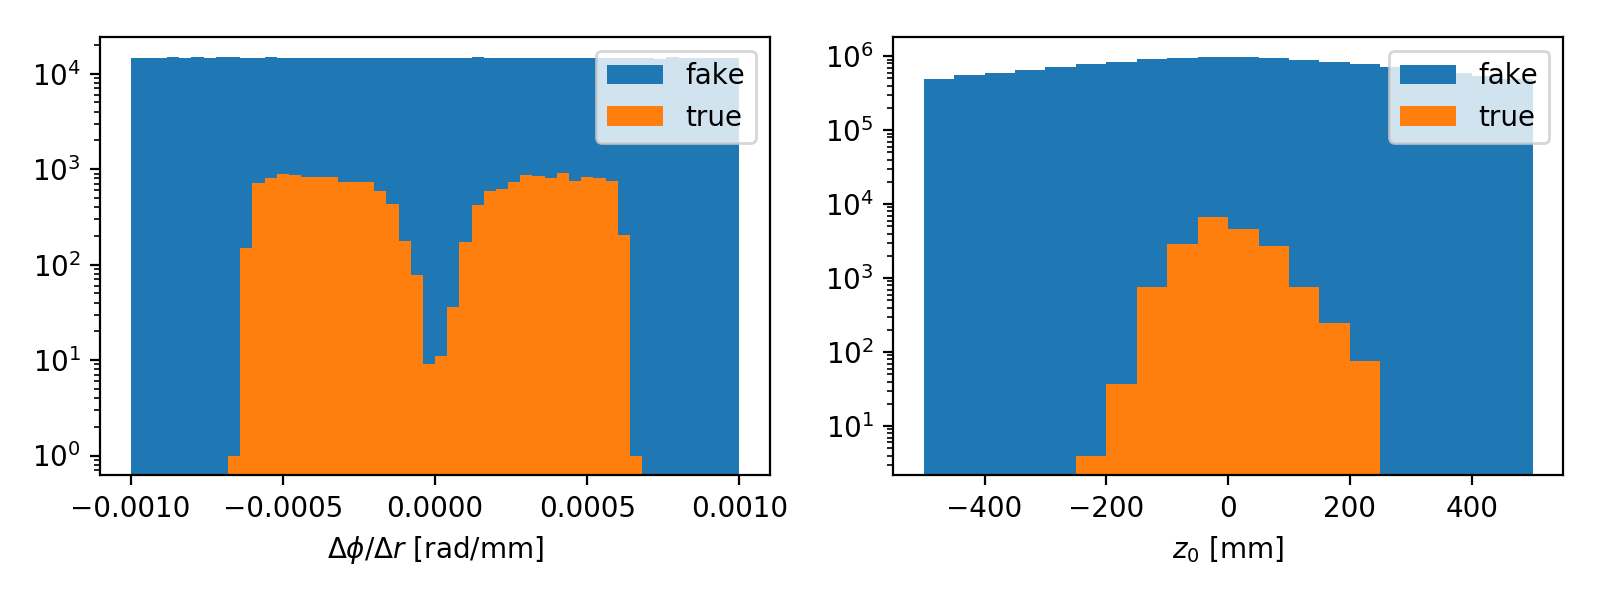

In [45]:
plt.figure(figsize=(8,3))

true_segs = inner_segments[inner_segments.y]
fake_segs = inner_segments[inner_segments.y == False]

plt.subplot(121)
binning=dict(bins=50, range=(-0.001, 0.001))
plt.hist(fake_segs.phi_slope, label='fake', log=True, **binning)
plt.hist(true_segs.phi_slope, label='true', **binning)
plt.xlabel('$\Delta \phi / \Delta r$ [rad/mm]')
plt.legend(loc=0)

plt.subplot(122)
binning=dict(bins=20, range=(-500, 500))
plt.hist(fake_segs.z0, label='fake', log=True, **binning)
plt.hist(true_segs.z0, label='true', **binning)
plt.xlabel('$z_0$ [mm]')
plt.legend(loc=0)

plt.tight_layout()

<IPython.core.display.Javascript object>


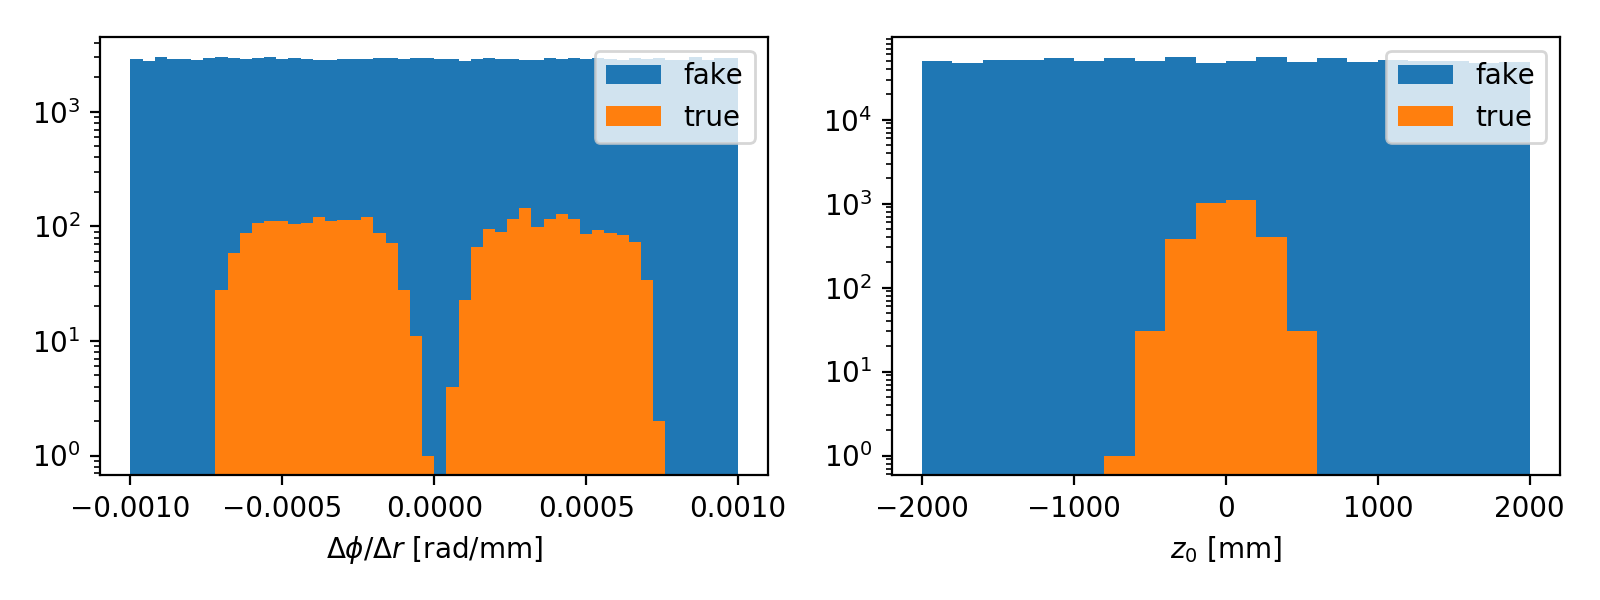

In [44]:
plt.figure(figsize=(8,3))

true_segs = outer_segments[outer_segments.y]
fake_segs = outer_segments[outer_segments.y == False]

plt.subplot(121)
binning=dict(bins=50, range=(-0.001, 0.001))
plt.hist(fake_segs.phi_slope, label='fake', log=True, **binning)
plt.hist(true_segs.phi_slope, label='true', **binning)
plt.xlabel('$\Delta \phi / \Delta r$ [rad/mm]')
plt.legend(loc=0)

plt.subplot(122)
binning=dict(bins=20, range=(-2000, 2000))
plt.hist(fake_segs.z0, label='fake', log=True, **binning)
plt.hist(true_segs.z0, label='true', **binning)
plt.xlabel('$z_0$ [mm]')
plt.legend(loc=0)

plt.tight_layout()

### Decide the edge criteria

It looks like I could use criteria like these to construct the graph:
- ($\Delta \phi / \Delta r$) < 0.001
- $|z_0| < 200$ if neither hits are on super-strips
- $|z_0| < 500$ if one or both hits are on super-strips

This won't be 100% efficient, but it looks like it should probably be ok for now.

## Construct graphs

Let's apply the procedure to construct graphs in the data, and then evaluate the purity/efficiency of the segments.

In [12]:
def select_segments(hits1, hits2, phi_slope_max, z0_max):
    """
    Construct a list of selected segments from the pairings
    between hits1 and hits2, filtered with the specified
    phi slope and z0 criteria.
    
    Returns: pd DataFrame of (index_1, index_2), corresponding to the
    DataFrame hit label-indices in hits1 and hits2, respectively.
    """
    # Start with all possible pairs of hits
    keys = ['evtid', 'r', 'phi', 'z']
    hit_pairs = hits1[keys].reset_index().merge(
        hits2[keys].reset_index(), on='evtid', suffixes=('_1', '_2'))
    # Compute line through the points
    dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
    dz = hit_pairs.z_2 - hit_pairs.z_1
    dr = hit_pairs.r_2 - hit_pairs.r_1
    phi_slope = dphi / dr
    z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr
    # Filter segments according to criteria
    good_seg_mask = (phi_slope.abs() < phi_slope_max) & (z0.abs() < z0_max)
    return hit_pairs[['index_1', 'index_2']][good_seg_mask]

def construct_segments(hits, layer_pairs,
                       phi_slope_max, z0_max_inner, z0_max_outer):
    """
    Construct a list of selected segments from hits DataFrame using
    the specified layer pairs and selection criteria.
    
    Returns: DataFrame of (index_1, index_2) corresponding to the
    hit indices of the selected segments.
    """
    # Loop over layer pairs and construct segments
    layer_groups = hits.groupby('layer')
    segments = []
    for (layer1, layer2) in layer_pairs:
        # Find and join all hit pairs
        hits1 = layer_groups.get_group(layer1)
        hits2 = layer_groups.get_group(layer2)
        # Segment criteria
        z0_max = z0_max_outer if (layer1 >= 8) or (layer2 >= 8) else z0_max_inner
        # Construct the segments
        segments.append(select_segments(hits1, hits2, phi_slope_max, z0_max))

    # Combine segments from all layer pairs
    return pd.concat(segments)

In [13]:
# Feature details
feature_names = ['r', 'phi', 'z']
n_features = len(feature_names)
feature_scale = np.array([1000., np.pi, 1000.])

# Segment selection criteria
phi_slope_max = 0.0007
z0_max_inner = 200
z0_max_outer = 500

In [20]:
# Construct layer pairs from adjacent layer numbers 
layers = np.arange(10)
layer_pairs = np.stack([layers[:-1], layers[1:]], axis=1)

# Organize hits by event
evt_hit_groups = hits.groupby('evtid')
evtids = hits.evtid.unique()

In [21]:
# Work with a single event for now
evtid = 0

In [22]:
# Get the hits from this event
evt_hits = evt_hit_groups.get_group(evtid)

In [23]:
# Construct segments
segments = construct_segments(evt_hits, layer_pairs,
                              phi_slope_max=phi_slope_max,
                              z0_max_inner=z0_max_inner,
                              z0_max_outer=z0_max_outer)

In [24]:
n_hits = evt_hits.shape[0]
n_edges = segments.shape[0]

In [25]:
print('Event', evtid, 'hits', n_hits, 'edges', n_edges)

Event 0 hits 13111 edges 57752


In [26]:
# Segment purity
pid1 = evt_hits.loc[segments.index_1].barcode
pid2 = evt_hits.loc[segments.index_2].barcode
(pid1.values == pid2.values).mean()

0.18560396176755783

In [27]:
n_hits * n_edges

757186472

In [28]:
# Prepare the tensors
X = evt_hits[feature_names].values / feature_scale
Ri = np.zeros((n_hits, n_edges), dtype=np.uint8)
Ro = np.zeros((n_hits, n_edges), dtype=np.uint8)
y = np.zeros(n_edges)

In [29]:
# We have the segments' hits given by dataframe label,
# so we need to translate into positional indices.
# Use a series to map hit label-index onto positional-index.
hit_idx = pd.Series(np.arange(n_hits), index=evt_hits.index)
seg_start = hit_idx.loc[segments.index_1].values
seg_end = hit_idx.loc[segments.index_2].values

In [30]:
# Now we can fill the association matrices.
# Note that Ri maps hits onto their incoming edges, which are actually segment endings.
Ri[seg_end, np.arange(n_edges)] = 1
Ro[seg_start, np.arange(n_edges)] = 1

In [31]:
# Fill the segment labels
pid1 = evt_hits.barcode.loc[segments.index_1].values
pid2 = evt_hits.barcode.loc[segments.index_2].values
y[:] = (pid1 == pid2)

<IPython.core.display.Javascript object>


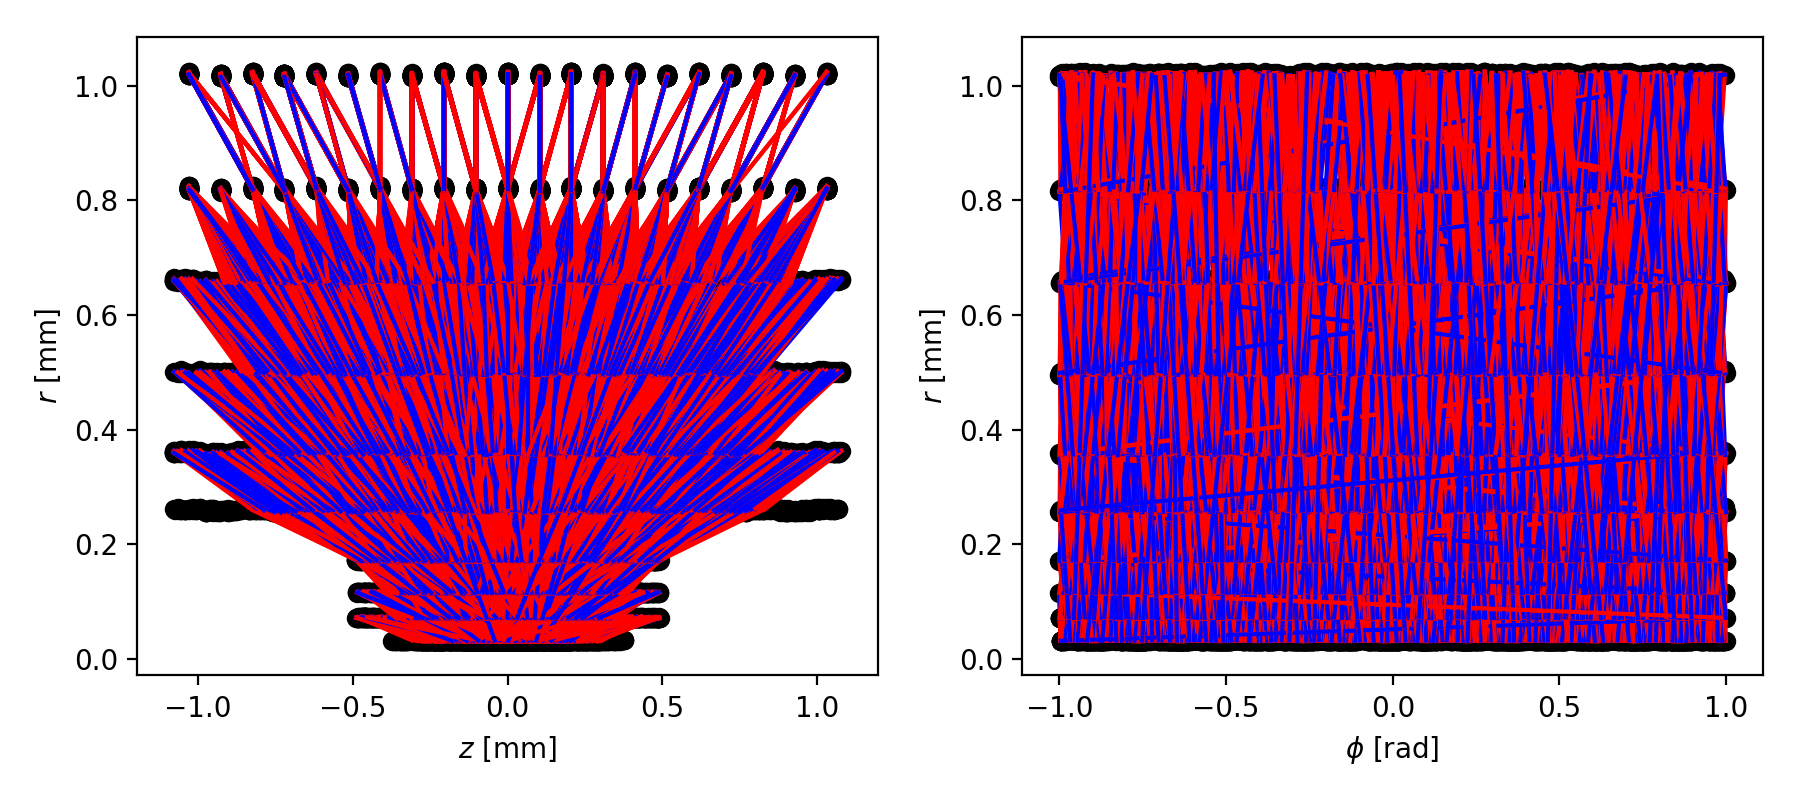

In [35]:
draw_sample(X, Ri, Ro, y)